<a href="https://colab.research.google.com/github/Jess-Lau/Real-Life-B-W-Video-Colorization-Project/blob/main/Image_Colorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Importing Libraries

from tensorflow.keras.utils import  array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

In [4]:
#Getting Images

X = []
for imagename in os.listdir('Dataset/Train/'):
    X.append(img_to_array(load_img('Dataset/Train/'+imagename, target_size=(256, 256))))
X = np.array(X, dtype=float)


# Set up train and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

#set up Test data
Xtest = X[split:]
Xtest = 1.0/255*Xtest

In [5]:
#CNN model

from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential

model = Sequential()

#Input Layer
model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))

#Hidden Layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

#Compiling the CNN
model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 269ms/step - accuracy: 0.4748 - loss: 0.0766
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 0.5795 - loss: 0.0098
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5735 - loss: 0.0106
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.5467 - loss: 0.0107
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.5962 - loss: 0.0098
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.5550 - loss: 0.0113
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.5518 - loss: 0.0097
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - accuracy: 0.5860 - loss: 0.0104
Epoch 9/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.5501 - loss: 0.0092
Epoch 10/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - accuracy: 0.5685 - loss: 0.0101
Epoch 11/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.5707 - loss: 0.0102
Epoch 12/500
30/30 ━━━━━━━━━━━━━━━━━

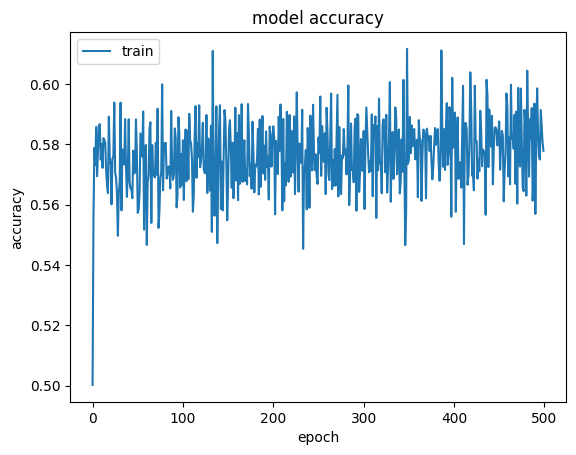

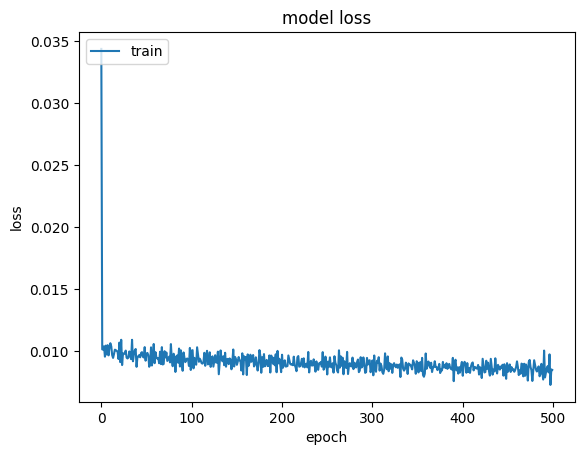

In [6]:
import matplotlib.pyplot as plt

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model
tensorboard = TensorBoard(log_dir="/output/beta_run")
trainedmodel = model.fit(image_a_b_gen(batch_size), callbacks=[tensorboard],epochs=500, steps_per_epoch=30)


# Summarize history for model accuracy
plt.plot(trainedmodel.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for model loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
# Save model

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.weights.h5")


In [8]:
# load json and create model

from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.weights.h5")

In [9]:
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 2)         │             578 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 256, 256, 2)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,784,390 (29.70 MB)

 Trainable params: 3,892,194 (14.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,892,196 (14.85 MB)

In [10]:
# Test images
loaded_model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(loaded_model.evaluate(Xtest, Ytest, batch_size=10))

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 939ms/step - accuracy: 0.6339 - loss: 0.0089
[0.00824803952127695, 0.616844892501831]


Output of the Model
Couldn't read image .DS_Store. Skipping.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


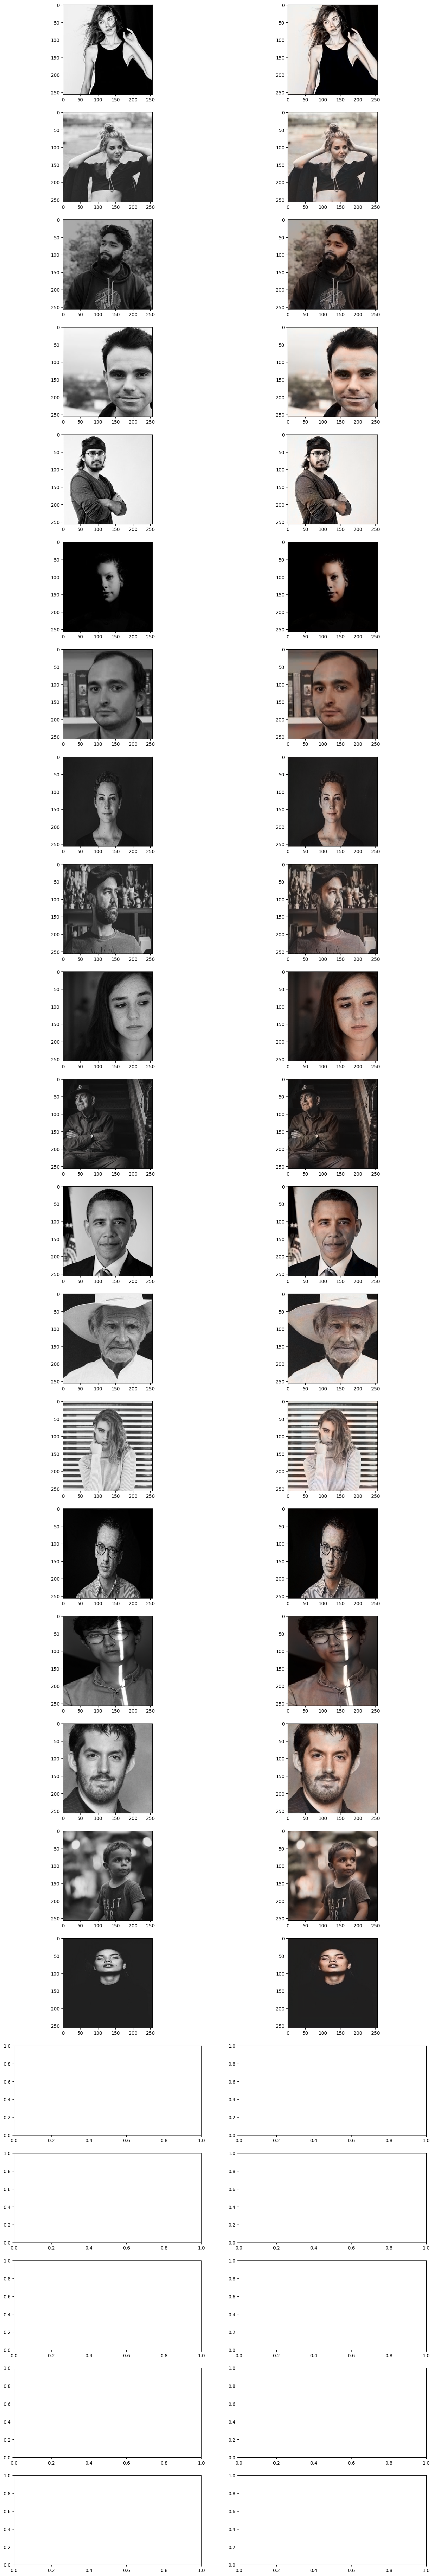

In [12]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from keras.models import model_from_json

# Load the model
def load_model():
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("model.weights.h5")
    loaded_model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
    return loaded_model

# Function to save colorized images
def save_colorized_image(image, filename, folder="Results"):
    if not os.path.exists(folder):
        os.makedirs(folder)
    cv2.imwrite(os.path.join(folder, filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Process and colorize images
def process_and_colorize_images(loaded_model):
    fig, ax = plt.subplots(24, 2, figsize=(16, 100))
    row = 0
    colorize = []

    print('Output of the Model')

    for filename in os.listdir('Dataset/Test/'):
        img = cv2.imread('Dataset/Test/' + filename)

        # Check if image is read correctly
        if img is None:
            print(f"Couldn't read image {filename}. Skipping.")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (256, 256))
        colorize.append(img_resized)

        ax[row, 0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB), interpolation='nearest')
        row += 1

    colorize = np.array(colorize, dtype=float)
    colorize = rgb2lab(1.0/255 * colorize)[:, :, :, 0]
    colorize = colorize.reshape(colorize.shape + (1,))

    # Test model
    output = loaded_model.predict(colorize)
    output *= 128

    row = 0

    # Output colorizations
    for i in range(len(output)):
        cur = np.zeros((256, 256, 3))
        cur[:, :, 0] = colorize[i][:, :, 0]
        cur[:, :, 1:] = output[i]
        resImage = lab2rgb(cur)

        # Save the colorized image
        save_colorized_image(np.uint8(resImage * 255), f"colorized_{i}.png")

        ax[row, 1].imshow(resImage, interpolation='nearest')
        row += 1

    plt.show()

# Load the model and process images
loaded_model = load_model()
process_and_colorize_images(loaded_model)
